### CS4102 - Geometric Foundations of Data Analysis I
Prof. Götz Pfeiffer<br />
School of Mathematics, Statistics and Applied Mathematics<br />
NUI Galway

# Week 11: Clustering

1. Implement the Clustering Algorithm (single-linkage)
2. Generate random clustered points
3. Compute distance matrix for given points
4. Apply (1) to (3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Distances

* From last week's discussion of abstract classes:

In [2]:
class Distance:
    def __init__(self, name):
        self.name = name

    def __repr__(self):
        return self.name

    def __call__(self, p, q):
        raise NotImplementedError(f"don't know yet how to {self}(p, q).")
        
    def flatten(self, p, q):
        p = np.array(p).flatten()
        q = np.array(q).flatten()
        return p - q

* Then all the subclasses essentially are one-liners ...

In [3]:
class EuclideanDist(Distance):
    def __call__(self, p, q):
        return np.sqrt(np.sum(self.flatten(p, q)**2))

In [4]:
e = EuclideanDist("e")
e([1,2,3],[4,5,6])

5.196152422706632

In [5]:
class TaxicabDist(Distance):
    def __call__(self, p, q):
        return np.sum(np.abs(self.flatten(p, q)))   

In [6]:
t = TaxicabDist("t")
t([1,2,3],[4,5,6])

9

In [7]:
class InfinityDist(Distance):
    def __call__(self, p, q):
        return np.max(np.abs(self.flatten(p, q)))   

In [8]:
i = InfinityDist("i")
i([1,2,3],[4,5,6])

3

## 2. Random Clusters

In [9]:
import random

* The `random` library has a `normalvariate` method that generates normally distributed data

In [10]:
random.normalvariate?

In [11]:
values = [random.normalvariate(2, 1) for _ in range(1000)]

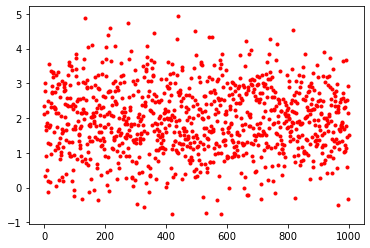

In [12]:
plt.plot(values, 'r.')

* Let's check how much of a bell curve is formed by these random data

In [13]:
from collections import Counter
bins = [int(5*x) for x in values]
counter = Counter(bins)
print(counter)

Counter({8: 84, 6: 83, 10: 81, 7: 71, 12: 68, 11: 67, 9: 62, 13: 57, 14: 55, 5: 53, 15: 49, 4: 49, 16: 33, 3: 33, 1: 27, 2: 23, 17: 22, 0: 20, 18: 18, -1: 10, 19: 10, 20: 6, 21: 6, 22: 4, -2: 3, -3: 3, 24: 2, 23: 1})


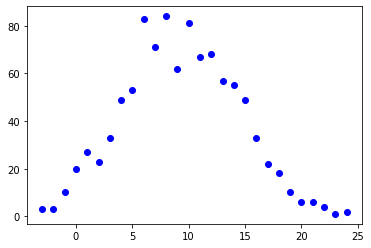

In [14]:
plt.plot(counter.keys(), counter.values(), 'bo')

* Now for a $2$-dimensional cluster ...

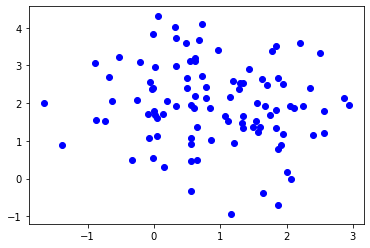

In [15]:
centre = (1,2)
count = 100
xx = [random.normalvariate(centre[0], 1) for _ in range(count)]
yy = [random.normalvariate(centre[1], 1) for _ in range(count)]
plt.plot(xx, yy, 'bo')

In [16]:
def cluster_points(centre, count, spread):
    xx = [random.normalvariate(centre[0], spread) for _ in range(count)]
    yy = [random.normalvariate(centre[1], spread) for _ in range(count)]
    return xx, yy

In [17]:
pp = cluster_points((0,0), 10, 1)
print(pp)

([-0.8063843821634142, 0.8315588209064603, 0.3362290444873822, -1.6580475316003027, -0.006801405517444444, -1.0824251083657934, 1.211953387773982, -0.6769598591818065, 1.4830863146006898, 1.1178018798449756], [-1.8675600394892344, -0.9443763155588863, -0.5364639476726738, -1.2157233874261129, 0.7949174642839627, -0.7417927524083485, -1.3535576663459148, -0.8377916342907049, -1.1591754291460816, -0.3377031301576309])


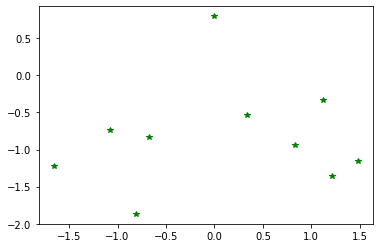

In [18]:
plt.plot(*pp, 'g*')

In [19]:
centres = [(x, y) for x in range(4) for y in range(4)]
print(centres)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


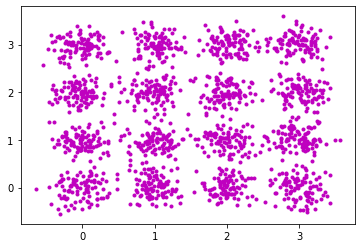

In [20]:
xx = []
yy = []
for c in centres:
    pp = cluster_points(c, 100, 0.2)
    xx.extend(pp[0])
    yy.extend(pp[1])
plt.plot(xx, yy, 'm.')

In [21]:
def random_clusters(centres, count, spread):
    xx = []
    yy = []
    for c in centres:
        pp = cluster_points(c, count, spread)
        xx.extend(pp[0])
        yy.extend(pp[1])
    return xx, yy

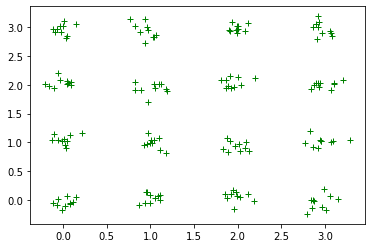

In [22]:
cc = random_clusters(centres, 10, 0.1)
plt.plot(*cc, 'g+')

## 1. Clustering Algorithm

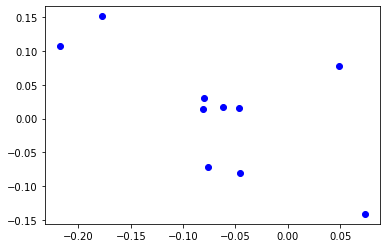

In [23]:
plt.plot(*cluster_points(centres[0], 10, 0.1 ),'bo')

* Sample data from the lectures.

In [24]:
distances = [
    [],
    [11],
    [10, 3],
    [14, 13, 12],
    [22, 21, 20, 16],
]
for j in range(5):
    for i in range(j):
        distances[i].append(distances[j][i])
    distances[j].append(0)
distances = np.array(distances, dtype=float)

In [25]:
distances

array([[ 0., 11., 10., 14., 22.],
       [11.,  0.,  3., 13., 21.],
       [10.,  3.,  0., 12., 20.],
       [14., 13., 12.,  0., 16.],
       [22., 21., 20., 16.,  0.]])

### Find

1. the minimal nonzero value
2. its $(i,j)$-position

* We'll try a 'naive' and straightforward method first

In [26]:
min_val = 10000
min_pos = None
r, c = distances.shape
r, c

(5, 5)

In [27]:
for i in range(r):
    for j in range(c):
        val = distances[i, j]
        if val and val < min_val:
            min_val = val
            min_pos = (i, j)
            

In [28]:
min_val

3.0

In [29]:
min_pos

(1, 2)

* Next, let's see how Numpy could help
* There is a function `np.min`

In [30]:
np.min?

In [31]:
np.min(distances)

0.0

* Oops. Of course we want a *nonzero* minimum.
* Let's try `np.max` instead.

In [32]:
np.max(distances)

22.0

* That looks right.
* But where in the matrixs is it?

In [33]:
np.max?

In [34]:
np.argmax(distances)

4

* And what is that supposed to mean?

In [35]:
np.argmax?

* Ah: it's the index in the flattened version of `distances`.
* To unravel its position in terms of rows and columns of the original matrix, we're told to use `unravel_index`.

In [36]:
np.unravel_index(np.argmax(distances), distances.shape)

(0, 4)

* Now for the minimum.
* In order to have Numpy ignore $0$s, we apply a trick and turn all $0$ entries into `np.nan`.
* The works because Numpy exposes the underlying IEEE 745 [floating point arithmetic](https://en.wikipedia.org/wiki/Floating-point_arithmetic)

In [37]:
for i in range(r):
    distances[i][i] = np.nan
distances

array([[nan, 11., 10., 14., 22.],
       [11., nan,  3., 13., 21.],
       [10.,  3., nan, 12., 20.],
       [14., 13., 12., nan, 16.],
       [22., 21., 20., 16., nan]])

In [38]:
np.min(distances)

nan

In [39]:
np.min?

In [40]:
np.nanmin(distances)

3.0

In [41]:
np.nanmin?

In [42]:
np.nanargmin(distances)

7

In [43]:
i, j = np.unravel_index(np.nanargmin(distances), distances.shape)
i, j

(1, 2)

In [44]:
distances[[i,j]]

array([[11., nan,  3., 13., 21.],
       [10.,  3., nan, 12., 20.]])

In [45]:
np.delete?

In [46]:
mat = np.delete(distances, (i,j), axis=1)
mat

array([[nan, 14., 22.],
       [11., 13., 21.],
       [10., 12., 20.],
       [14., nan, 16.],
       [22., 16., nan]])

In [47]:
mat[[i,j]]

array([[11., 13., 21.],
       [10., 12., 20.]])

In [48]:
new = np.min(mat[[i,j]], axis=0)
new

array([10., 12., 20.])

In [49]:
mat = np.delete(mat, (i,j), axis=0)
mat

array([[nan, 14., 22.],
       [14., nan, 16.],
       [22., 16., nan]])

In [50]:
mat = np.append(mat, [new], axis=0)
mat

array([[nan, 14., 22.],
       [14., nan, 16.],
       [22., 16., nan],
       [10., 12., 20.]])

In [51]:
new = np.append(new, [np.nan], axis=0)
new

array([10., 12., 20., nan])

In [52]:
mat = np.append(mat, new.reshape(-1, 1), axis=1)
mat

array([[nan, 14., 22., 10.],
       [14., nan, 16., 12.],
       [22., 16., nan, 20.],
       [10., 12., 20., nan]])

* Collate these operations into a function (assuming that the diagonal values of `distances` are `np.nan`):

In [53]:
def collapse(distances):
    min_val = np.nanmin(distances)
    i, j = np.unravel_index(np.nanargmin(distances), distances.shape)
    mat = np.delete(distances, (i,j), axis=1)
    new = np.min(mat[[i,j]], axis=0)
    mat = np.delete(mat, (i,j), axis=0)
    mat = np.append(mat, [new], axis=0)
    new = np.append(new, [np.nan], axis=0)
    mat = np.append(mat, new.reshape(-1, 1), axis=1)
    return min_val, mat

In [54]:
collapse(distances)

(3.0,
 array([[nan, 14., 22., 10.],
        [14., nan, 16., 12.],
        [22., 16., nan, 20.],
        [10., 12., 20., nan]]))

In [55]:
L = [0]
mat = distances

In [56]:
val, mat = collapse(mat)
L.append(val)
mat

array([[nan, 14., 22., 10.],
       [14., nan, 16., 12.],
       [22., 16., nan, 20.],
       [10., 12., 20., nan]])

In [57]:
val, mat = collapse(mat)
L.append(val)
mat

array([[nan, 16., 12.],
       [16., nan, 20.],
       [12., 20., nan]])

In [58]:
val, mat = collapse(mat)
L.append(val)
mat

array([[nan, 16.],
       [16., nan]])

In [59]:
val, mat = collapse(mat)
L.append(val)
mat

array([[nan]])

In [60]:
L

[0, 3.0, 10.0, 12.0, 16.0]

### Clustering Algorithm

In [61]:
def clustering(distances):
    L = [0.0]
    mat = distances
    while len(mat) > 1:
        val, mat = collapse(mat)
        L.append(val)
    return L

In [62]:
clustering(distances)

[0.0, 3.0, 10.0, 12.0, 16.0]

## 3. Distance Matrix

In [63]:
def distances(points, dist):
    dist = np.array([[dist(x, y) for x in points] for y in points])
    for i in range(len(dist)):
        dist[i][i] = np.nan
    return dist

In [64]:
e

e

In [65]:
points = np.array(cc).T
points[0]

array([ 0.08032858, -0.06067338])

In [66]:
dd = distances(points, e)
dd

array([[       nan, 0.07543048, 0.15457498, ..., 4.17700045, 4.21328023,
        4.17928188],
       [0.07543048,        nan, 0.09913462, ..., 4.25237806, 4.28862711,
        4.2544072 ],
       [0.15457498, 0.09913462,        nan, ..., 4.305636  , 4.34108148,
        4.30326771],
       ...,
       [4.17700045, 4.25237806, 4.305636  , ...,        nan, 0.05459023,
        0.22145775],
       [4.21328023, 4.28862711, 4.34108148, ..., 0.05459023,        nan,
        0.18477044],
       [4.17928188, 4.2544072 , 4.30326771, ..., 0.22145775, 0.18477044,
               nan]])

## 4. Apply (1) to (3)

In [67]:
clu = clustering(dd)
print(clu)

[0.0, 0.004670465337157519, 0.007977940846986883, 0.010234715367348391, 0.01166507545587486, 0.011678127122868842, 0.013168023618653815, 0.015885957035014782, 0.018586694406618948, 0.018590693812622017, 0.019707836536727856, 0.022074679762480485, 0.02256473976597319, 0.023035133733303653, 0.023544364512332924, 0.024429282363324843, 0.0283890415534324, 0.029341201529538685, 0.029576686730747904, 0.02977790793116927, 0.03160023748319287, 0.03650907244845774, 0.037542244219455845, 0.037783376052239324, 0.03890008389039178, 0.04065110540956018, 0.04127739921063796, 0.04171638567399876, 0.041996634892595794, 0.042668179855901045, 0.04270934231293517, 0.04302663286114743, 0.043443072799268005, 0.04415533571114621, 0.04499074763699631, 0.046233683557236074, 0.04665384662746331, 0.04733236062218987, 0.047472725209835316, 0.04829290399448806, 0.04862359264629537, 0.04872135573902156, 0.0493890567437687, 0.049609655172611324, 0.0510355270019762, 0.052199401747630846, 0.05304149902663935, 0.05459

* Barcodes:

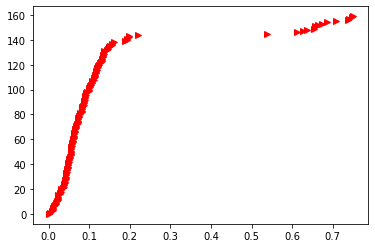

In [68]:
plt.plot(clu, range(160), 'r>')

<BarContainer object of 160 artists>

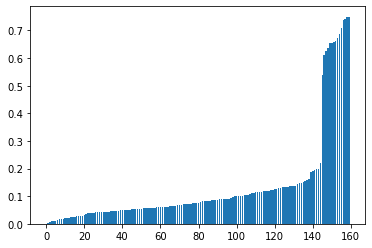

In [69]:
plt.bar(range(160), clu)

In [70]:
clu[160 - 16]

0.21954052566833326

In [71]:
clu[160 - 16 + 1]

0.5372378950210077